In [1]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
matplotlib.use('Agg')
#matplotlib.style.use('ggplot')
from numpy import mean
from numpy import sort
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

Matplotlib is building the font cache; this may take a moment.


In [8]:
#The CSV file includes Data from the SPARQL query
df=pd.read_csv('sparql-11.csv')

In [9]:
df.columns

Index(['area', 'price18', 'price17', 'sales17', 'births17', 'busscore17',
       'busscoreweekend17', 'derelict17', 'derelictall17', 'childbenefit17',
       'familiesbenefit17', 'popall17', 'death17', 'occup17', 'longempty17',
       'sechomes17', 'totaldwel17', 'ill17', 'depr17', 'alco17', 'mortality17',
       'unempl17', 'unempcountl17', 'flatsratio17', 'flatscount17', 'rooms17',
       'hectare17'],
      dtype='object')

In [10]:
df = df.rename(columns = {'sales17':'House Sales', 'births17':'Births', 'busscore17':'Bus Accessibility (weekday)', 'busscoreweekend17':'Bus Accessibility (weekend)', 'derelictall17':'Derelict Population', 'childbenefit17':'Children/Child Benefits', 'familiesbenefit17':'Families/Child Benefits', 'popall17':'Population', 'deadth17':"Deaths", 'occup17':'Occupied Dwellings', 'longempty17':'Long Empty Dwellings', 'sechomes17':'Second Homes', 'totaldwel17':'Total Dwellings', 'ill17':'Comparative Illness Factor', 'depr17':'Anxiety/Depression', 'alco17':'Alcohol Misuse', 'mortality17':'Standarized Mortality Ratio', 'unempl17':'Employment Deprived (Percentage)', 'unempcountl17':'Employment Deprived (count)', 'flatsratio17':'Flats (ratio)', 'flatscount17':'Flats (count)', 'rooms17':'Rooms in Dwellings', 'hectare17':'Dwellings per hectar'})

In [12]:
df['y'] = df['price17'] > df.price17.mean()
df=df.drop(columns=['area','price18', 'price17','derelict17'])
X, y = df.drop('y', axis=1), df.y

In [13]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [14]:
paramGrid = {
         "learning_rate":[0.1],
         "n_estimators":[400],
         "max_depth": [3],
         "subsample": [0.8],
         "colsample_bytree": [0.6],
         "colsample_bylevel": [0.8]
            }  

model = XGBClassifier(nthread=10)

cv = StratifiedKFold()

gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)

fit = gridsearch.fit(X_train, y_train)

print(fit.best_score_)

print(fit.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.8, colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=  13.0s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=  17.0s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=  15.3s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=  15.4s
[CV] END colsample_bylevel=0.8, colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=  13.0s
0.9143871596903066
{'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}


In [15]:
fit.score(X_test, y_test)

0.9093505869155883

In [16]:
best = fit.best_estimator_

In [17]:
explainer = shap.TreeExplainer(best)

In [18]:
shap_values = explainer.shap_values(X)

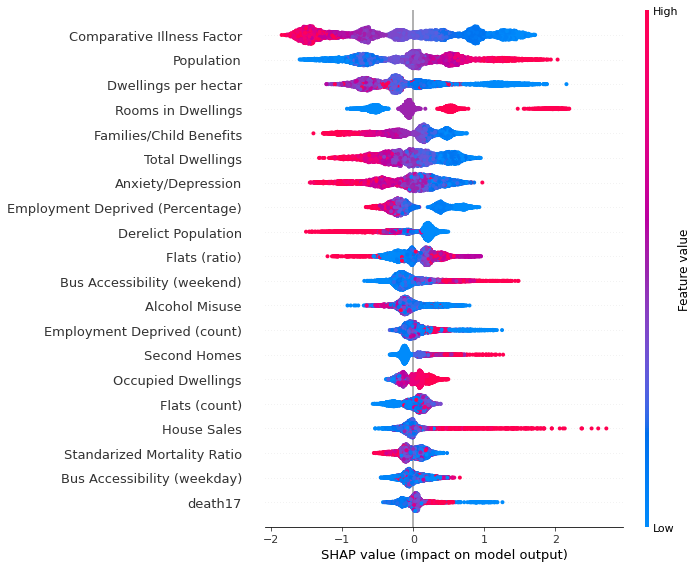

In [19]:
%matplotlib inline


shap.summary_plot(shap_values, X)

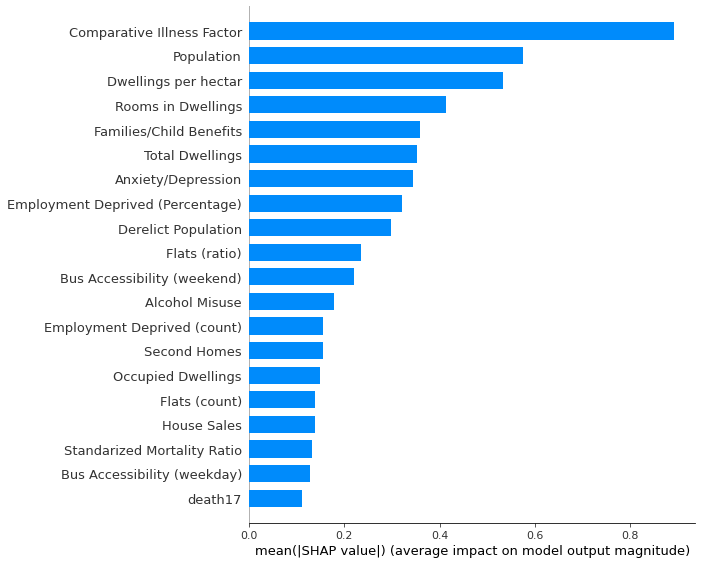

In [20]:
%matplotlib inline
shap.summary_plot(shap_values, X, plot_type="bar")

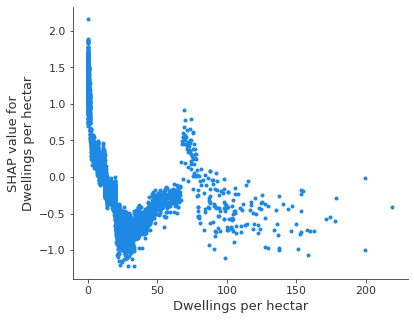

In [21]:
for x in X.columns:
    shap.dependence_plot(x, shap_values, X, interaction_index=None)

In [22]:
shap_interaction_values = shap.TreeExplainer(best).shap_interaction_values(X.iloc[:,:])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


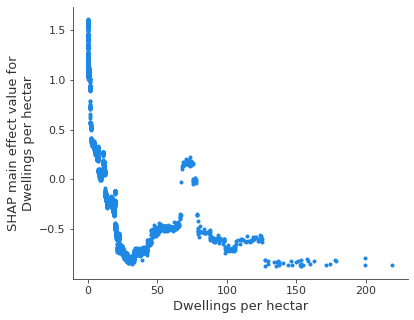

In [23]:
for x in X.columns:
    for y in X.columns:
        shap.dependence_plot(
            (x, y),
            shap_interaction_values, X.iloc[:,:]
        )